# Imports & Notebook Setup

We will import the necessary packages utilized for EDA/preprocessing in this notebook. We also make sure that our viualizations are exported to results/figures/eda & preprocessing/ directory:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append(os.path.abspath(".."))
from src.preprocessing import prepare_ais_data

# Export figures to results/figures/eda & preprocessing/ directory
FIG_DIR = "../results/figures/eda & preprocessing/"
os.makedirs(FIG_DIR, exist_ok=True)
_plt_original_show = plt.show
_plt_fig_counter = {"count": 0}
def _save_and_show(*args, **kwargs) -> None:
    _plt_fig_counter["count"] += 1
    filename = os.path.join(FIG_DIR, f"figure_{_plt_fig_counter['count']:03d}.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    _plt_original_show(*args, **kwargs)
plt.show = _save_and_show

Compilation complete


- `pandas` will help us load the CSV, handle missing values, etc.
- `numpy` will help us with numerical operations, arrays, and other data handling tools.
- `matplotlib` will help us with base plotting.
- `seaborn` provides nicer visualizations and better defaults for base plotting.
- `os` & `sys` helps us modify Python import paths (for custom modules).
- `src.preprocessing` contains utility functions for AIS data cleaning, outlier filtering, feature engineering, and sklearn-ready preprocessing.

# Initial EDA

We import the data from `ais_data.csv` to understand what we are working with in terms of the dataset's structure, quality, and the raw patterns that exist. This will help us determine what we need to keep and drop, which will assist us in creating a schematic for our preprocessing tasks.

## Loading & Inspecting Dataset Structure

Understand the shape, feature types, and identify ID-like columns.

In [2]:
ais_data = pd.read_csv("../data/ais_data.csv")

# Peek at structure
ais_data.head()

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


In [3]:
# Data types + missing counts
ais_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358351 entries, 0 to 358350
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          358351 non-null  int64  
 1   mmsi                358351 non-null  int64  
 2   navigationalstatus  358351 non-null  object 
 3   sog                 357893 non-null  float64
 4   cog                 355182 non-null  float64
 5   heading             337737 non-null  float64
 6   shiptype            358351 non-null  object 
 7   width               354640 non-null  float64
 8   length              354608 non-null  float64
 9   draught             332808 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 27.3+ MB


In [4]:
# Numerical summary
ais_data.describe()

,Unnamed: 0,mmsi,sog,cog,heading,width,length,draught
count,358351.000000,3.583510e+05,357893.000000,355182.000000,337737.000000,354640.000000,354608.000000,332808.000000
mean,186757.775285,2.939678e+08,12.122554,189.064529,190.076829,19.947854,124.971549,6.571402
std,112181.601870,1.213866e+08,9.355851,107.588825,107.107604,10.808627,71.268183,2.934392
min,0.000000,9.112856e+06,0.000000,0.000000,0.000000,1.000000,2.000000,0.400000
25%,89587.500000,2.195780e+08,9.200000,116.300000,120.000000,12.000000,83.000000,4.600000
50%,179947.000000,2.486590e+08,11.300000,168.700000,170.000000,17.000000,115.000000,6.100000
75%,283503.500000,3.046650e+08,13.300000,300.175000,303.000000,28.000000,181.000000,7.900000
max,387581.000000,9.921950e+08,214.000000,359.900000,507.000000,78.000000,690.000000,25.500000


In [5]:
# List of ALL column names
all_columns = list(ais_data.columns)
print("All columns:", all_columns)

# Target column identification
target_column = "navigationalstatus"
print("Target column:", target_column)

# ID fields (case insensitive/loose matching)
id_fields = []
possible_id_fields = ["mmsi", "imo", "callsign", "shipname"]
for col in ais_data.columns:
    if col.lower() in possible_id_fields:
        id_fields.append(col)
print("ID fields:", id_fields)

# Static features
static_features = []
for col in ais_data.columns:
    if col.lower() in ["width", "length", "draught", "shiptype"]:
        static_features.append(col)
print("Static features:", static_features)

# Dynamic features
dynamic_features = []
for col in ais_data.columns:
    if col.lower() in ["sog", "cog", "heading", "rot"]:
        dynamic_features.append(col)
print("Dynamic features:", dynamic_features)

All columns: ['Unnamed: 0', 'mmsi', 'navigationalstatus', 'sog', 'cog', 'heading', 'shiptype', 'width', 'length', 'draught']
Target column: navigationalstatus
ID fields: ['mmsi']
Static features: ['shiptype', 'width', 'length', 'draught']
Dynamic features: ['sog', 'cog', 'heading']


## Data Quality Checks 

Cleanliness assessment before deciding what to keep.

In [6]:
# Count missing values per column
ais_data.isna().sum()

Unnamed: 0                0
mmsi                      0
navigationalstatus        0
sog                     458
cog                    3169
heading               20614
shiptype                  0
width                  3711
length                 3743
draught               25543
dtype: int64

In [7]:
# Check for duplicate rows
dup_count = ais_data.duplicated().sum()
print(f"Duplicate rows found: {dup_count}")
if dup_count > 0:
    print("Duplicated rows:")
    print(ais_data[ais_data.duplicated()])

Duplicate rows found: 0


In [8]:
# Check for unrealistic Speeed-over-Ground (SOG) values: SOG < 0 or SOG > 60 knots.
unreal_sog = ais_data[(ais_data["sog"] < 0) | (ais_data["sog"] > 60)]
print("Unrealistic SOG rows:", len(unreal_sog))
unreal_sog[["mmsi", "navigationalstatus", "sog"]].head()

Unrealistic SOG rows: 2888


,mmsi,navigationalstatus,sog
1518,111219513,Under way using engine,69.2
1527,111219513,Under way using engine,102.2
1537,111219513,Under way using engine,102.2
1540,111219513,Under way using engine,102.2
1544,111219513,Under way using engine,102.2


In [9]:
# Check for unrealistic heading outside values: [0, 360] range in degrees.
unreal_heading = ais_data[ais_data["heading"] < 0] | ais_data[ais_data["heading"] > 360]
print("Unrealistic heading rows:", len(unreal_heading))
unreal_heading[["mmsi", "navigationalstatus", "heading"]].head()

Unrealistic heading rows: 4


,mmsi,navigationalstatus,heading
145692,False,False,False
157056,False,False,False
257390,False,False,False
354713,False,False,False


In [10]:
# Check for unrealistic draught (How deep the ship is submerged in the water in meters) values: Draught <= 0 m. 
unreal_draught = ais_data[ais_data["draught"] <= 0]
print("Nonpositive draught rows:", len(unreal_draught))
unreal_draught[["mmsi", "shiptype", "length", "width", "draught"]].head()

Nonpositive draught rows: 0


,mmsi,shiptype,length,width,draught


In [11]:
# Check for unrealistic length/widths: Length <= 0 or Width <= 0 or Length > 400 or Width > 60.
unreal_size = ais_data[
    (ais_data["length"] <= 0) | (ais_data["width"] <= 0) |
    (ais_data["length"] > 400) | (ais_data["width"] > 60)
]
print("Unrealistic length/width rows:", len(unreal_size))
unreal_size[["mmsi", "shiptype", "length", "width"]].head()

Unrealistic length/width rows: 56


,mmsi,shiptype,length,width
76551,211422510,Tanker,690.0,28.0
124552,219013964,Reserved,295.0,78.0
124636,219013964,Reserved,295.0,78.0
124777,219013964,Reserved,295.0,78.0
124879,219013964,Reserved,295.0,78.0


In [12]:
# Speed-over-Ground (SOG) validity check
ais_data["sog"].describe()

count    357893.000000
mean         12.122554
std           9.355851
min           0.000000
25%           9.200000
50%          11.300000
75%          13.300000
max         214.000000
Name: sog, dtype: float64

In [13]:
# Heading validity check
ais_data["heading"].describe()

count    337737.000000
mean        190.076829
std         107.107604
min           0.000000
25%         120.000000
50%         170.000000
75%         303.000000
max         507.000000
Name: heading, dtype: float64

In [14]:
# Draught validity check
ais_data["draught"].describe()

count    332808.000000
mean          6.571402
std           2.934392
min           0.400000
25%           4.600000
50%           6.100000
75%           7.900000
max          25.500000
Name: draught, dtype: float64

In [15]:
# Length validity check
ais_data["length"].describe()


count    354608.000000
mean        124.971549
std          71.268183
min           2.000000
25%          83.000000
50%         115.000000
75%         181.000000
max         690.000000
Name: length, dtype: float64

In [16]:
# Width validity check
ais_data["width"].describe()

count    354640.000000
mean         19.947854
std          10.808627
min           1.000000
25%          12.000000
50%          17.000000
75%          28.000000
max          78.000000
Name: width, dtype: float64

In [17]:
# Ship Type validity check
ais_data["shiptype"].describe()

count     358351
unique        17
top        Cargo
freq      190027
Name: shiptype, dtype: object

## Raw Patterns & Explorations

Reveal the structure of the target and predictor relationships.

### Target Variable (Navigational Status) Distribution:

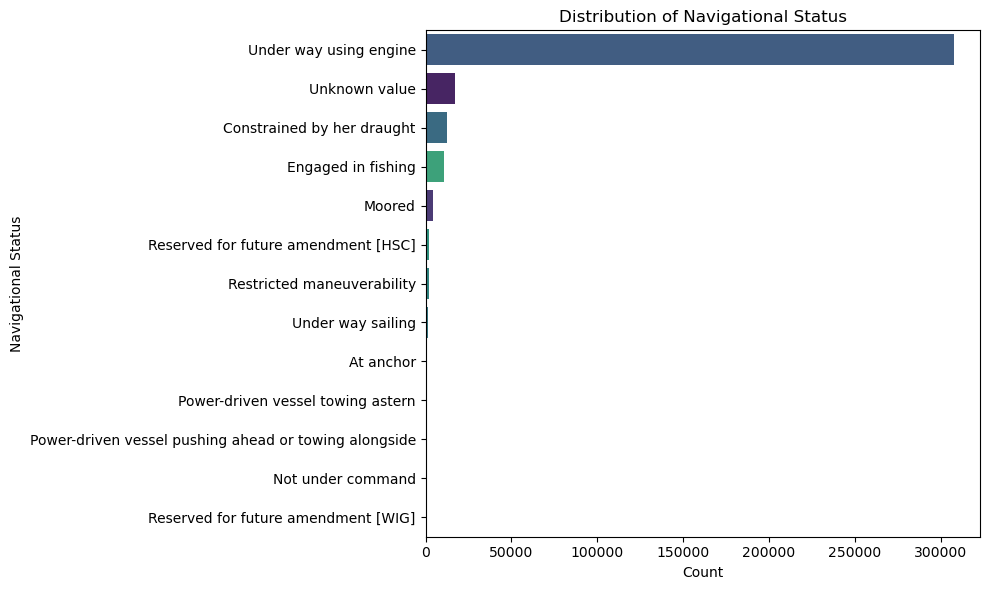

In [18]:
# Target variable distribution: Horizontal bar chart for Navigational Status (target variable) distribution
plt.figure(figsize=(10, 6))
sns.countplot(
    y="navigationalstatus",
    data=ais_data,
    order=ais_data["navigationalstatus"].value_counts().index,
    hue="navigationalstatus",
    palette='viridis',
    legend=False
)
plt.title("Distribution of Navigational Status")
plt.xlabel("Count")
plt.ylabel("Navigational Status")
plt.tight_layout()
plt.show()


This visualization shows a highly imbalanced distribution of navigational status classes. 

“Under way using engine” overwhelmingly dominated the dataset compared to all other categories. Most remaining statuses occur extremely rarely, indicating that the classification problem will be challenging and may require techniques such as class weighting or resampling to handle the imbalance.

This shows that this dataset is overwhelmingly dominated by vessels under way using engine, indicating that most ships in the Kattegat Strait were actively transiting rather than engaged in alternative navigational states.

### Feature Distributions:


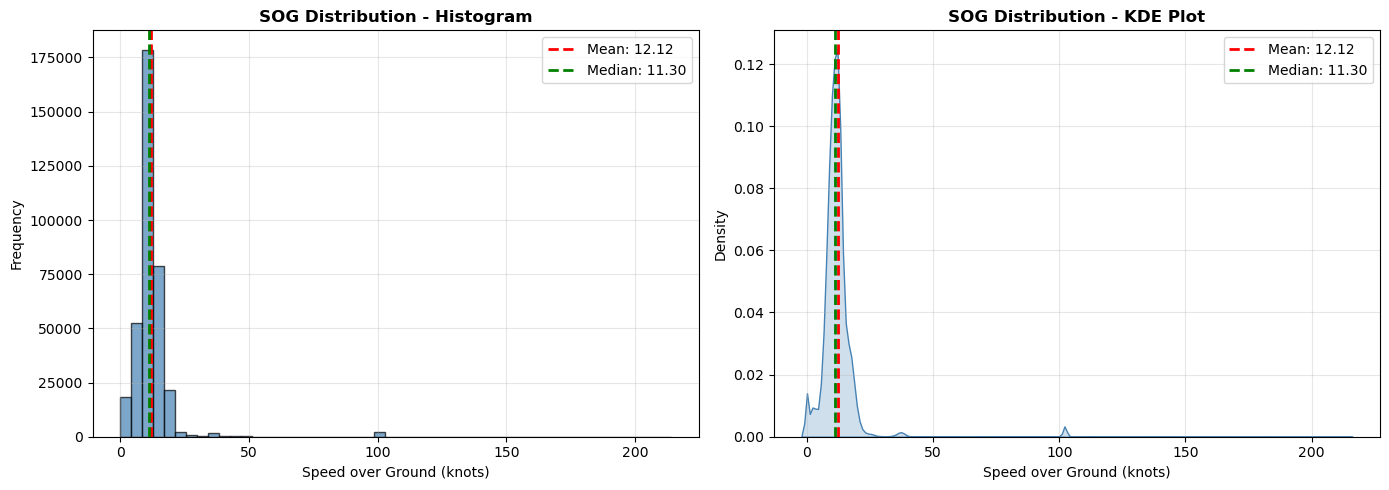

In [19]:
# SOG (Speed over Ground) Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

data = ais_data["sog"].dropna()
axes[0].hist(data, bins=50, alpha=0.7, color="steelblue", edgecolor="black") # Histogram
axes[0].axvline(data.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data.mean():.2f}")
axes[0].axvline(data.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data.median():.2f}")
axes[0].set_title("SOG Distribution - Histogram", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Speed over Ground (knots)")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sns.kdeplot(data=data, ax=axes[1], fill=True, color='steelblue') # KDE Plot
axes[1].axvline(data.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data.mean():.2f}")
axes[1].axvline(data.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data.median():.2f}")
axes[1].set_title("SOG Distribution - KDE Plot", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Speed over Ground (knots)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The Speed-over-Ground (SOG) histogram shows that most vessels move at moderate speeds, with most values falling between about 5 and 20 knots. 

Both the histogram and the Kernel Density Estimate (KDE) plot point out a strong right-skew from some extreme outliers - some even above 100 knots - which is not realistic for actual ships. 

This means the usual vessel speeds here are about 12 knots, and the high values are probably due to AIS errors or noise that should be addressed during preprocessing.

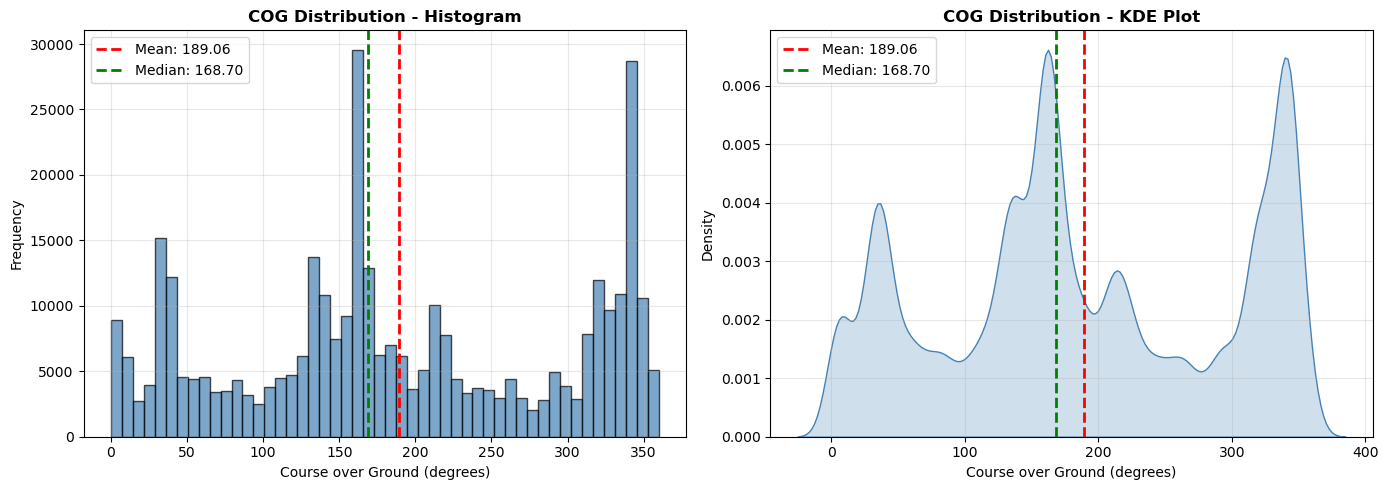

In [20]:
# COG (Course over Ground) Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

data = ais_data["cog"].dropna()
axes[0].hist(data, bins=50, alpha=0.7, color="steelblue", edgecolor="black") # Histogram
axes[0].axvline(data.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data.mean():.2f}")
axes[0].axvline(data.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data.median():.2f}")
axes[0].set_title("COG Distribution - Histogram", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Course over Ground (degrees)")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sns.kdeplot(data=data, ax=axes[1], fill=True, color='steelblue') # KDE Plot
axes[1].axvline(data.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data.mean():.2f}")
axes[1].axvline(data.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data.median():.2f}")
axes[1].set_title("COG Distribution - KDE Plot", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Course over Ground (degrees)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The Course-over-Ground (COG) histogram shows that ships travel in several main directions, not just one, with clear peaks at common headings like 0°, 90°, 180°, and 350°. 

These peaks match typical traffic routes in the strait. The KDE plot makes this even clearer by showing several tight groups instead of one smooth curve, which means most vessels follow a handful of main directions. 

This means that ship movement through the Kattegat Strait mostly happens along a few set paths, which are probably shaped by common shipping routes and traffic rules.

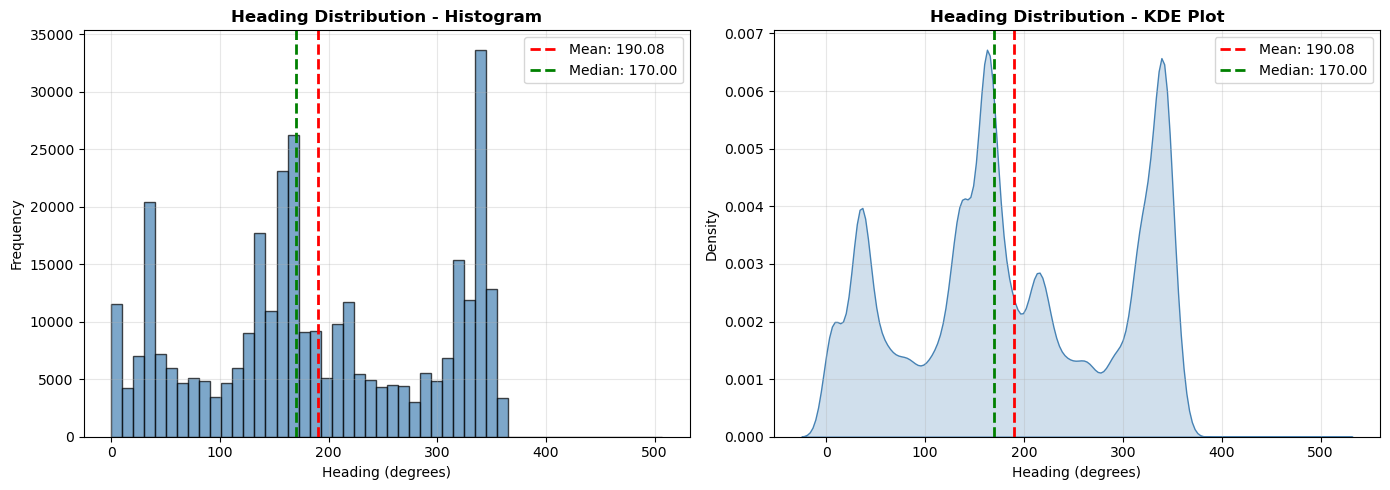

In [21]:
# Heading Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

data = ais_data["heading"].dropna()
axes[0].hist(data, bins=50, alpha=0.7, color="steelblue", edgecolor="black")
axes[0].axvline(data.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data.mean():.2f}")
axes[0].axvline(data.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data.median():.2f}")
axes[0].set_title("Heading Distribution - Histogram", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Heading (degrees)")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sns.kdeplot(data=data, ax=axes[1], fill=True, color="steelblue")
axes[1].axvline(data.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data.mean():.2f}")
axes[1].axvline(data.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data.median():.2f}")
axes[1].set_title("Heading Distribution - KDE Plot", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Heading (degrees)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The heading histogram shows a strong pattern with distinct groups at specific angles where ships steer their bows - not spread evenly or randomly. 

This is different from Course-over-Ground (COG), which shows the direction the ship is actually moving across the water, while heading is simply where the front of the ship is pointing, even if the ship is drifting sideways. 

The KDE plot highlights these sharp peaks, making it even clearer that ships follow a few main headings over and over, instead of all directions equally. 

This data shows that ship traffic mainly follows fixed routes, with vessels almost always pointing their bows along well-established lanes in this area.

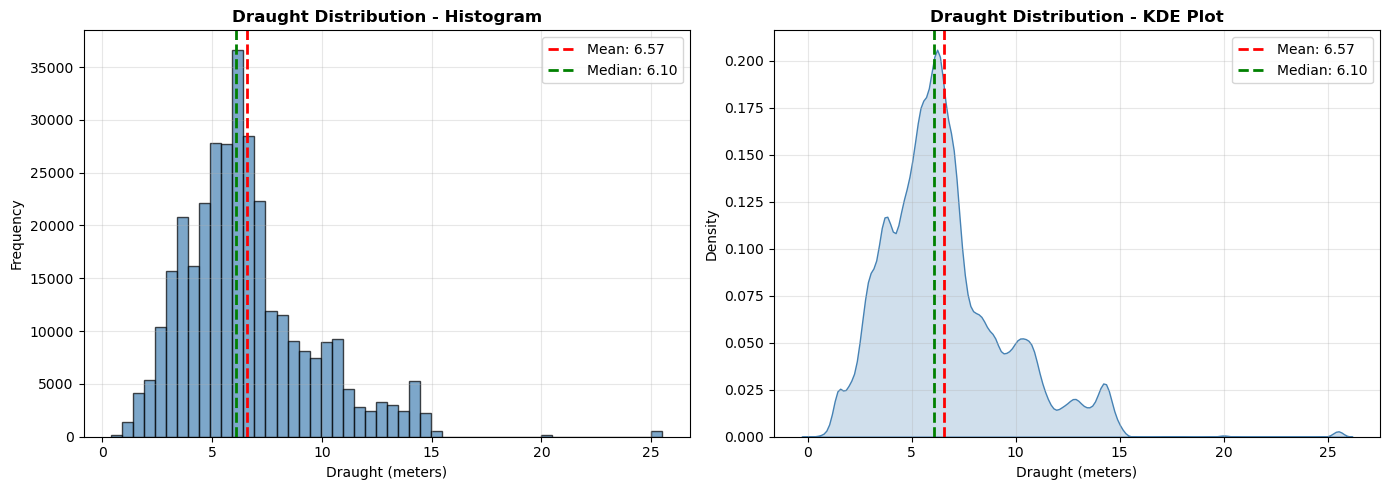

In [22]:
# Draught Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

data = ais_data["draught"].dropna()
axes[0].hist(data, bins=50, alpha=0.7, color="steelblue", edgecolor="black")
axes[0].axvline(data.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data.mean():.2f}")
axes[0].axvline(data.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data.median():.2f}")
axes[0].set_title("Draught Distribution - Histogram", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Draught (meters)")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sns.kdeplot(data=data, ax=axes[1], fill=True, color='steelblue')
axes[1].axvline(data.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data.mean():.2f}")
axes[1].axvline(data.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data.median():.2f}")
axes[1].set_title("Draught Distribution - KDE Plot", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Draught (meters)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The draught histogram shows that most vessels have draughts between about 4 and 9 meters, with the mean and median also in this range. 

The KDE plot also shows this main group and a long right tail with fewer ships over 10 meters. 

This means most ships in the Kattegat Strait are medium-draught cargo or tanker vessels, with only a few deeper-loaded or very large ships.

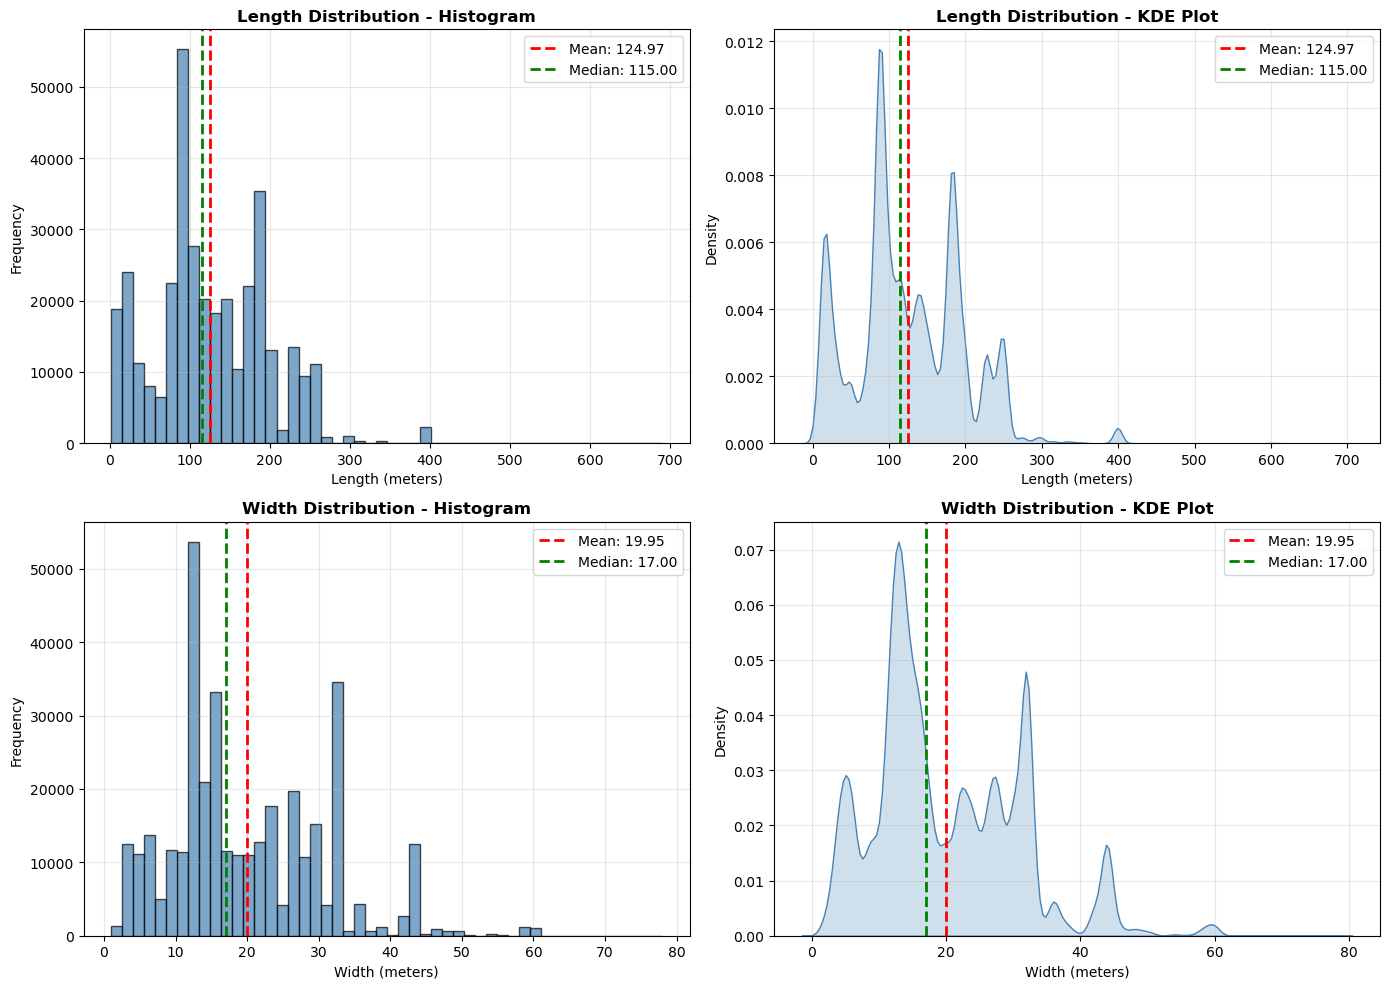

In [23]:
# Length/Width Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Length
data_length = ais_data["length"].dropna()
axes[0, 0].hist(data_length, bins=50, alpha=0.7, color="steelblue", edgecolor="black")
axes[0, 0].axvline(data_length.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data_length.mean():.2f}")
axes[0, 0].axvline(data_length.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data_length.median():.2f}")
axes[0, 0].set_title("Length Distribution - Histogram", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Length (meters)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

sns.kdeplot(data=data_length, ax=axes[0, 1], fill=True, color="steelblue")
axes[0, 1].axvline(data_length.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data_length.mean():.2f}")
axes[0, 1].axvline(data_length.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data_length.median():.2f}")
axes[0, 1].set_title("Length Distribution - KDE Plot", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Length (meters)")
axes[0, 1].set_ylabel("Density")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Width
data_width = ais_data["width"].dropna()
axes[1, 0].hist(data_width, bins=50, alpha=0.7, color="steelblue", edgecolor="black")
axes[1, 0].axvline(data_width.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data_width.mean():.2f}")
axes[1, 0].axvline(data_width.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data_width.median():.2f}")
axes[1, 0].set_title("Width Distribution - Histogram", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Width (meters)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

sns.kdeplot(data=data_width, ax=axes[1, 1], fill=True, color="steelblue")
axes[1, 1].axvline(data_width.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {data_width.mean():.2f}")
axes[1, 1].axvline(data_width.median(), color="green", linestyle="--", linewidth=2, label=f"Median: {data_width.median():.2f}")
axes[1, 1].set_title("Width Distribution - KDE Plot", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Width (meters)")
axes[1, 1].set_ylabel("Density")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The length and width histograms show several clear peaks, not just one, meaning there are distinct groups of vessel sizes. 

The KDE plots confirm this, with multiple bumps likely matching groups like small fishing boats, medium cargo ships, and large tankers. 

This suggests that ships in the Kattegat Strait come from different size categories, each with its own typical range.

### Per-class Behavior Patterns:

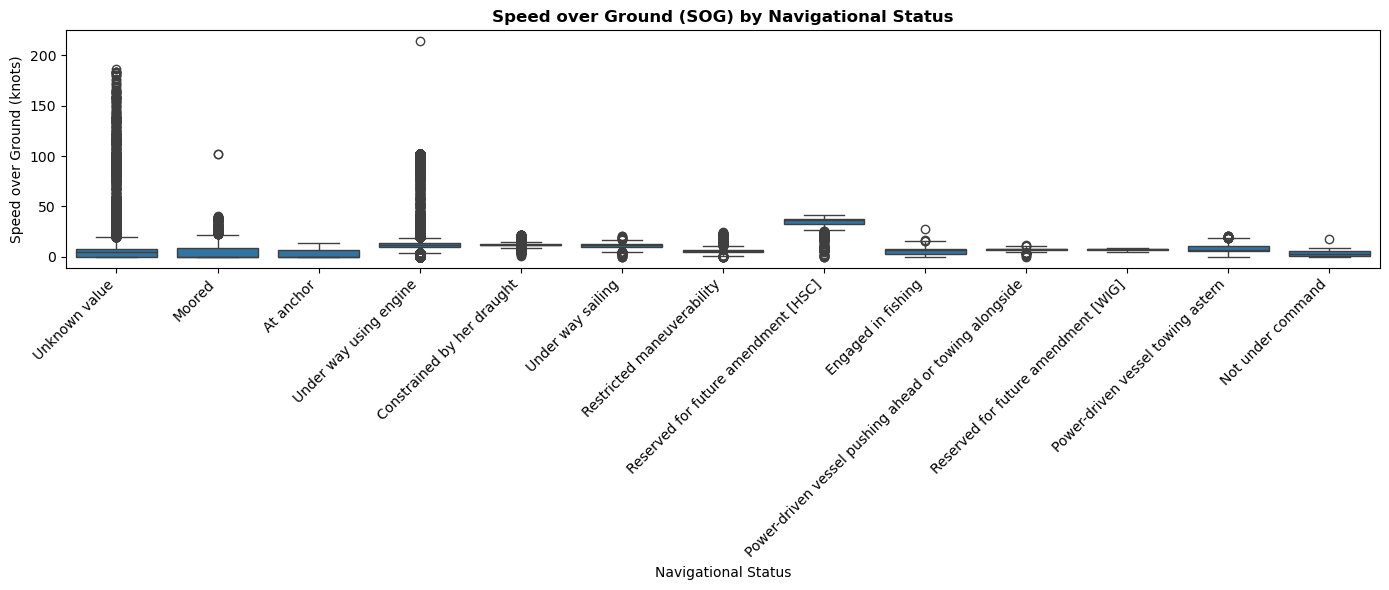

In [24]:
# SOG by Navigational Status
plt.figure(figsize=(14, 6))
sns.boxplot(x="navigationalstatus", y="sog", data=ais_data)
plt.title("Speed over Ground (SOG) by Navigational Status", fontsize=12, fontweight="bold")
plt.xlabel("Navigational Status")
plt.ylabel("Speed over Ground (knots)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The boxplot shows clear speed differences across navigational status categories, with vessels “under way using engine” exhibiting the widest spread and highest typical speeds. 

In contrast, statuses like “moored,” “at anchor,” and “not under command” cluster tightly near zero, reflecting minimal or no vessel movement. 

The “Unknown value” category seems to result from missing or incorrect AIS status reports, not an actual navigational state. This is shown by its very inconsistent speed patterns and unrealistic outliers, so it should be seen as a data-quality issue rather than a meaningful class.

Overall, the visualization indicates that SOG is a strong discriminator between active transit and stationary or restricted operational states, making it a highly informative feature for navigational status prediction.

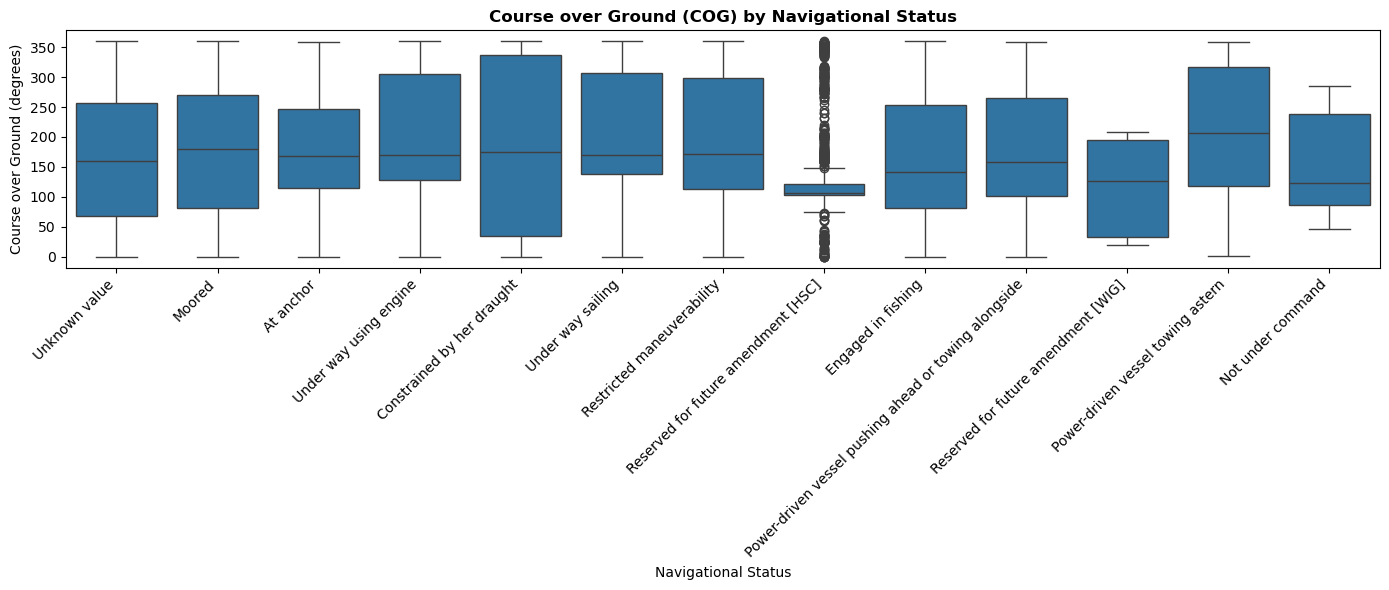

In [25]:
# COG by Navigational Status
plt.figure(figsize=(14, 6))
sns.boxplot(x="navigationalstatus", y="cog", data=ais_data)
plt.title("Course over Ground (COG) by Navigational Status", fontsize=12, fontweight="bold")
plt.xlabel("Navigational Status")
plt.ylabel("Course over Ground (degrees)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The boxplot shows that COG varies widely for almost all navigational statuses, with many groups spreading nearly across the full 0–360° range. 

Some categories, like “Reserved for future amendment [HSC]” and “Power-driven vessel towing astern,” have more tightly grouped values, but others, such as “Under way using engine” and “Constrained by her draught,” have COG values covering many directions. 

The “Unknown value” category seems to result from missing or incorrect AIS status reports, not an actual navigational state. This is shown by its very inconsistent patterns and unrealistic outliers, so it should be seen as a data-quality issue rather than a meaningful class.

This means that COG by itself does not clearly distinguish between navigational statuses, since vessels in most categories can head in almost any direction.

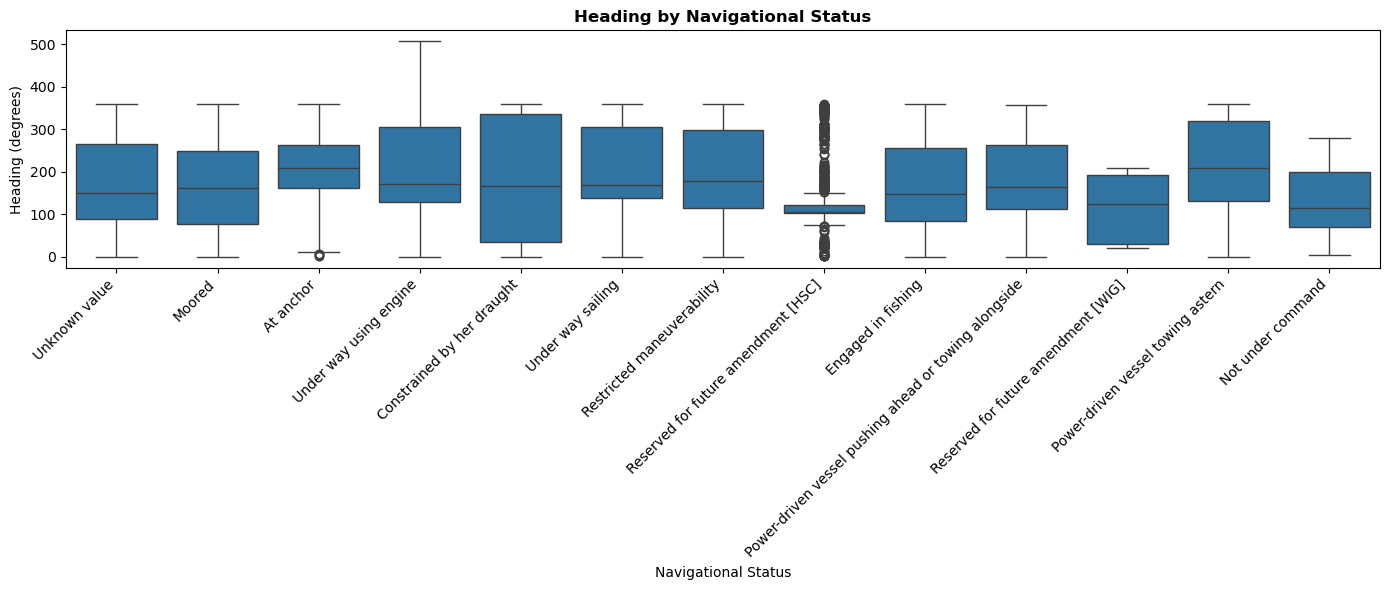

In [26]:
# Heading by Navigational Status
plt.figure(figsize=(14, 6))
sns.boxplot(x="navigationalstatus", y="heading", data=ais_data)
plt.title("Heading by Navigational Status", fontsize=12, fontweight="bold")
plt.xlabel("Navigational Status")
plt.ylabel("Heading (degrees)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The heading boxplot shows that most navigational statuses cover almost the entire 0–360° range, just like with COG. 

However, while a few categories such as “Reserved for future amendment [HSC]” have more tightly grouped headings, most statuses overlap a lot. 

The “Unknown value” category seems to result from missing or incorrect AIS status reports, not an actual navigational state. This is shown by its very inconsistent patterns and unrealistic outliers, so it should be seen as a data-quality issue rather than a meaningful class.

This means that both heading and COG show wide variation across all statuses, but heading patterns alone do not help much to tell different statuses apart, since vessels in different groups can have very similar headings.

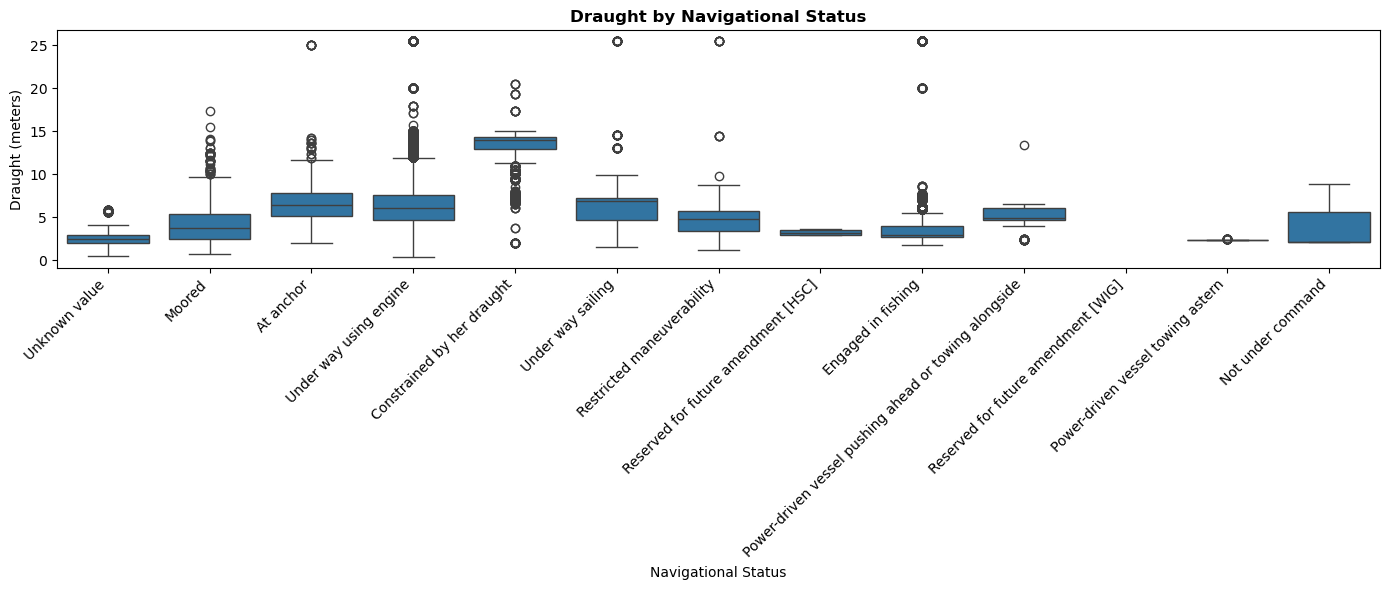

In [27]:
# Draught by Navigational Status
plt.figure(figsize=(14, 6))
sns.boxplot(x="navigationalstatus", y="draught", data=ais_data)
plt.title("Draught by Navigational Status", fontsize=12, fontweight="bold")
plt.xlabel("Navigational Status")
plt.ylabel("Draught (meters)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The boxplot shows that draught differs greatly between navigational statuses. Some categories, like “Constrained by her draught” and “Engaged in fishing,” have much higher typical draught values. 

Other statuses - such as “Reserved for future amendment [HSC]” and “Power-driven vessel towing astern” - have very small draught ranges, meaning the vessels in those groups are more similar in size. 

The “Unknown value” category seems to result from missing or incorrect AIS status reports, not an actual navigational state. This is shown by its very inconsistent patterns and unrealistic outliers, so it should be seen as a data-quality issue rather than a meaningful class.

This plot suggests that draught can help tell apart certain navigational statuses, especially those linked to larger or more heavily loaded ships.

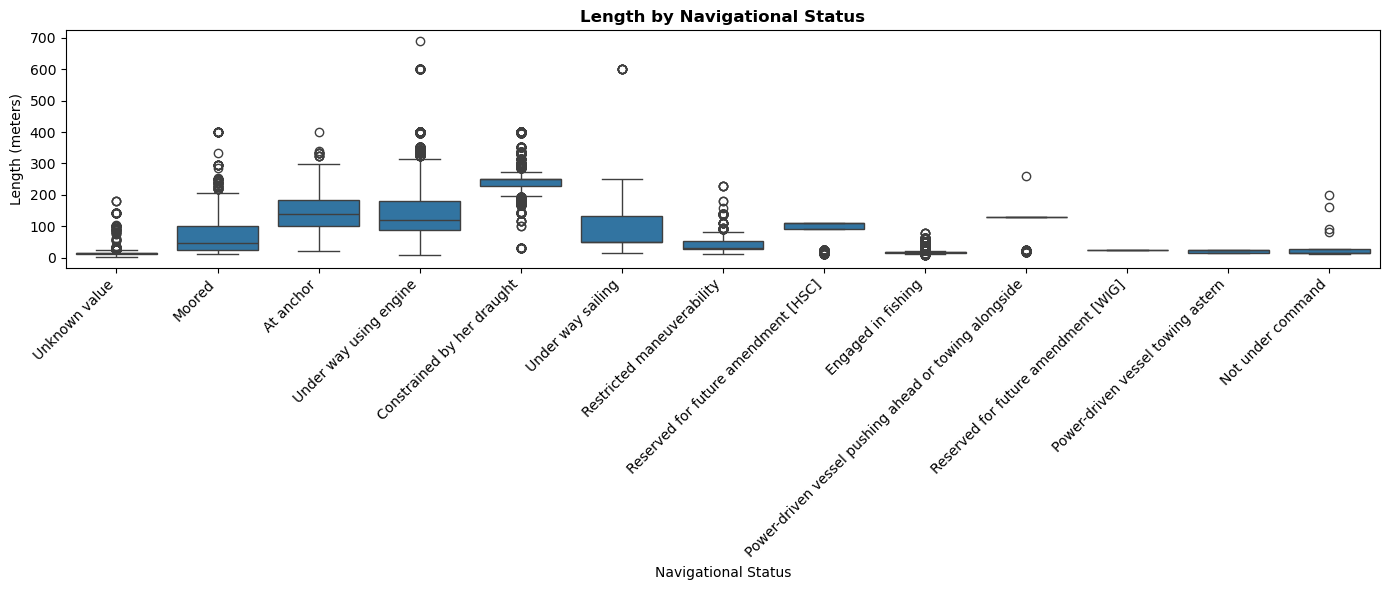

In [28]:
# Length by Navigational Status
plt.figure(figsize=(14, 6))
sns.boxplot(x="navigationalstatus", y="length", data=ais_data)
plt.title("Length by Navigational Status", fontsize=12, fontweight="bold")
plt.xlabel("Navigational Status")
plt.ylabel("Length (meters)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

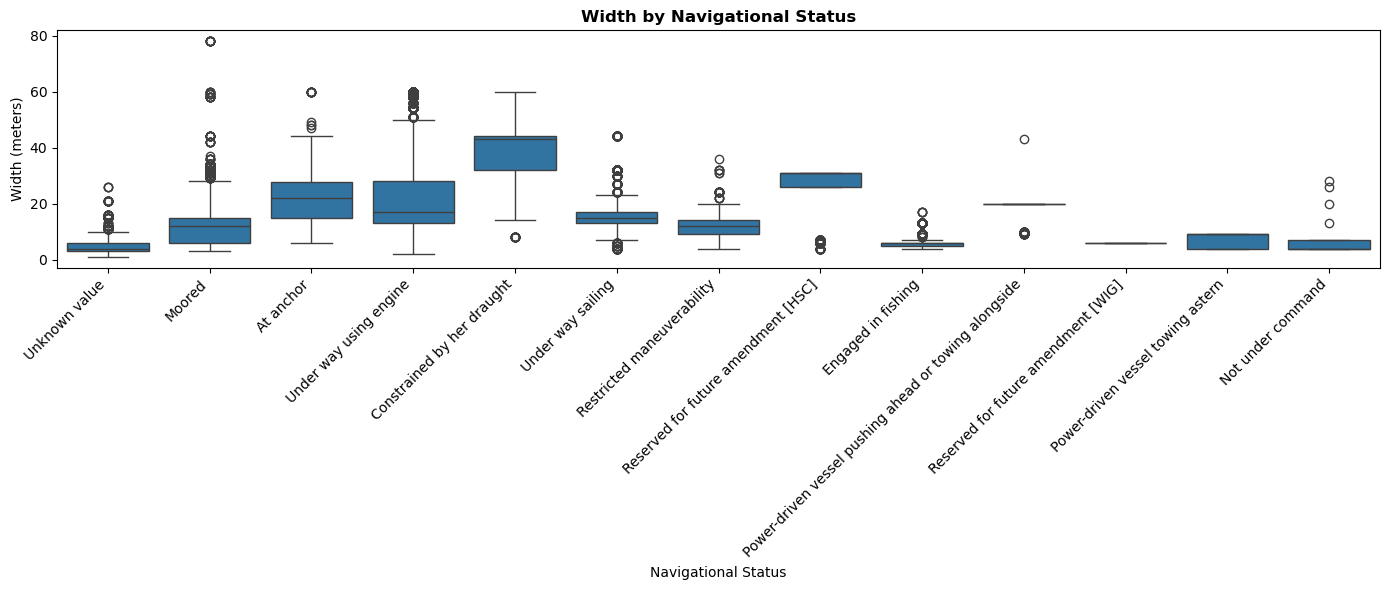

In [29]:
# Width by Navigational Status
plt.figure(figsize=(14, 6))
sns.boxplot(x="navigationalstatus", y="width", data=ais_data)
plt.title("Width by Navigational Status", fontsize=12, fontweight="bold")
plt.xlabel("Navigational Status")
plt.ylabel("Width (meters)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These visualizations show that both vessel length and width change a lot between navigational statuses. 

The biggest and widest ships are mostly found in active movement groups like "Under way using engine", "Constrained by her draught", and "Under way sailing". 

In contrast, stationary or specialized groups - like "Moored", "Engaged in fishing", and "Power-driven vessel towing astern" - have smaller and narrower ships with much less variation. 

The “Unknown value” category seems to result from missing or incorrect AIS status reports, not an actual navigational state. This is shown by its very inconsistent patterns and unrealistic outliers, so it should be seen as a data-quality issue rather than a meaningful class.

This suggests that the data suggests that large, wide ships are usually used for active travel or deep-water work, while smaller ships are found in non-moving or specialized roles.

### Ship Type Distribution:

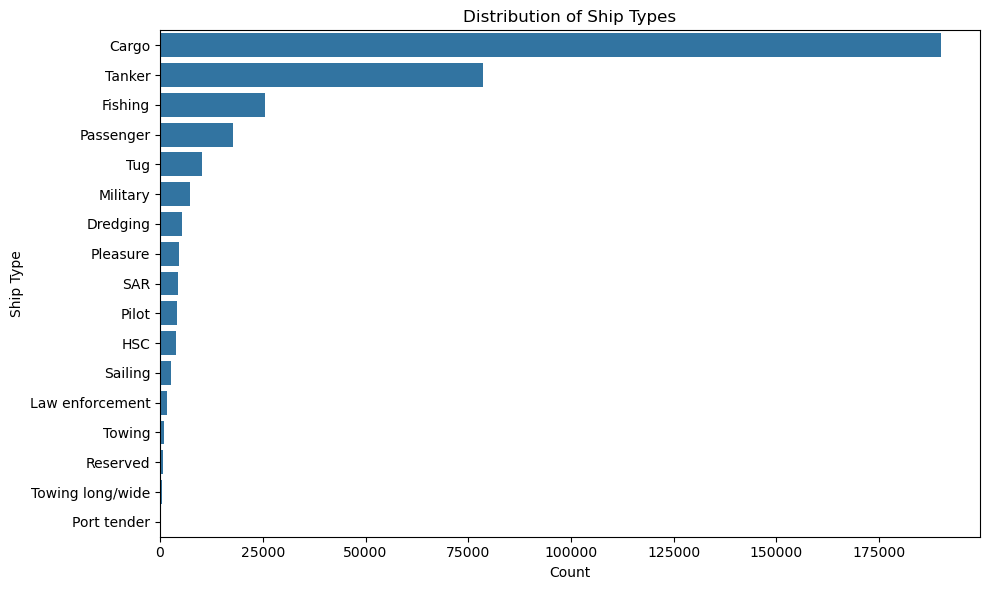

In [30]:
# Shiptype Distribution
plt.figure(figsize=(10, 6))
sns.countplot(
    y="shiptype",
    data=ais_data,
    order=ais_data["shiptype"].value_counts().index
)
plt.title("Distribution of Ship Types")
plt.xlabel("Count")
plt.ylabel("Ship Type")
plt.tight_layout()
plt.show()

This bar chart shows the distribution of ship types in the dataset, with Cargo vessels appearing overwhelmingly more frequently than any other category. 

Tankers and Fishing vessels form the next largest groups, while specialized or smaller vessel types - such as Pilot, SAR, Sailing, and Port Tenders - occur far less often. 

This dataset is heavily dominated by commercial shipping (Cargo and Tanker), indicating that most AIS activity in this sample comes from large-scale maritime trade.

### Correlation Heatmap (Numeric Features Only):

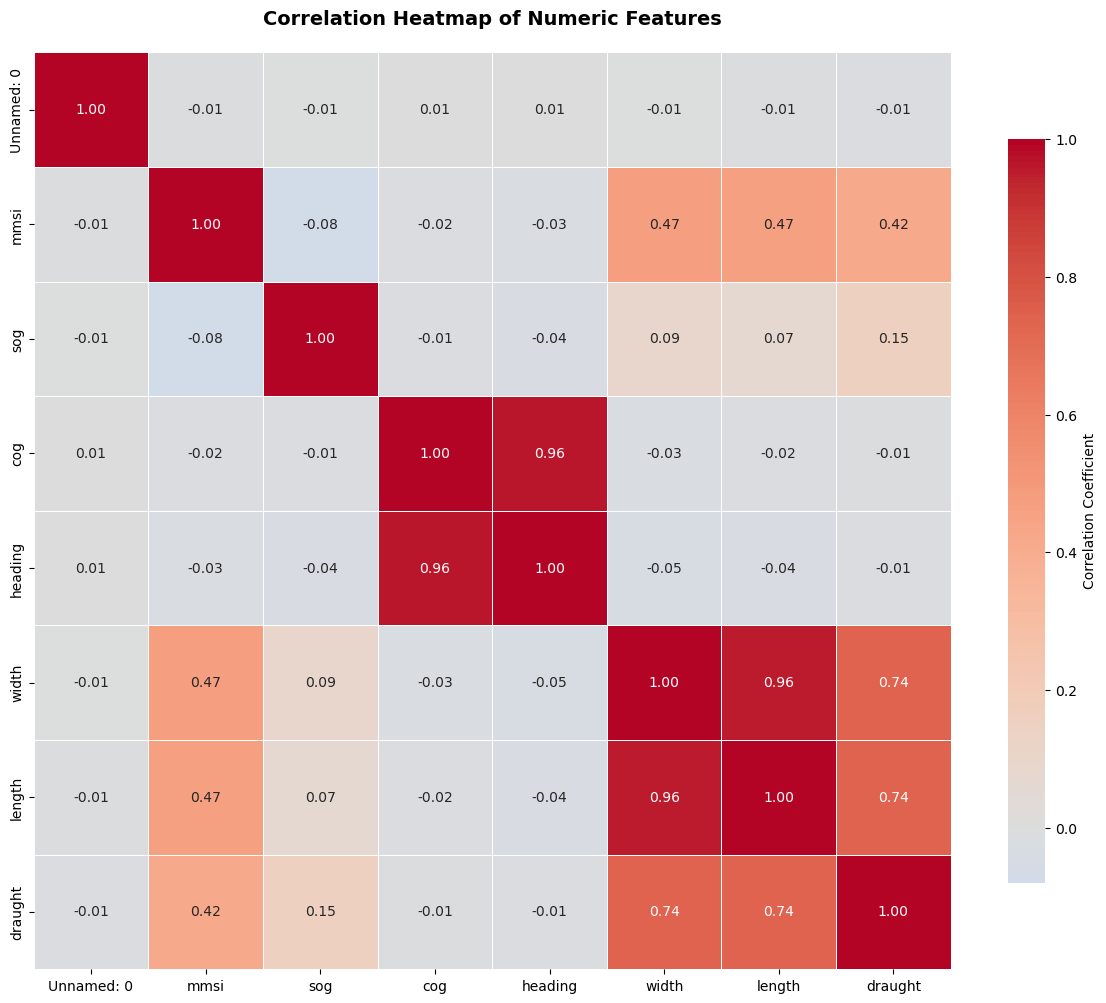


Strong Correlations (|r| > 0.7):
cog - heading: 0.962
width - length: 0.956
width - draught: 0.741
length - draught: 0.736


In [31]:
numeric_cols = ais_data.select_dtypes(include=["float64", "int64"]).columns
correlation_matrix = ais_data[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()
print("\nStrong Correlations (|r| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            print(f"{correlation_matrix.columns[i]} - {correlation_matrix.columns[j]}: {corr_value:.3f}")

This heatmap shows how the numeric AIS features are related. 

There is a very strong relationship between course over ground and heading, and high correlations between ship size features like width, length, and draught. 

One unusual result is that MMSI, which should just be a vessel ID, is moderately correlated (0.42-0.47) with ship size. 

This means MMSI is accidentally carrying information about vessel type, country, or class, which causes data leakage. 

Because of this, both MMSI and the extra index column Unnamed: 0 must be dropped before training a model. 

Ship size features are naturally related, but MMSI's correlation shows it can't be used as a predictor.

### Scatter Relationship Checks:

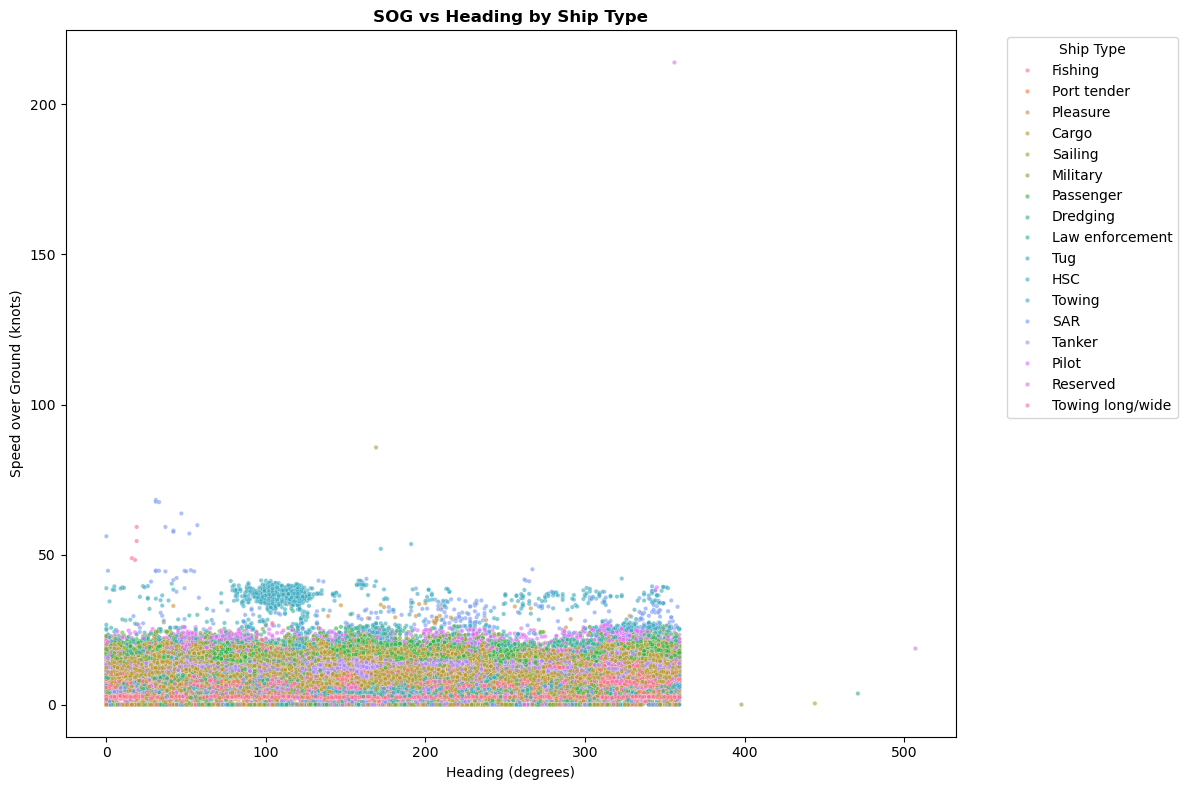

In [32]:
# SOG vs Heading (colored by Ship Type)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="heading",
    y="sog",
    data=ais_data,
    hue="shiptype",
    alpha=0.6,
    s=10
)
plt.title("SOG vs Heading by Ship Type", fontsize=12, fontweight="bold")
plt.xlabel("Heading (degrees)")
plt.ylabel("Speed over Ground (knots)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Ship Type')
plt.tight_layout()
plt.show()

This scatter plot shows heading versus SOG for all ship types. 

Most ships travel at low or moderate speeds, with clusters below 25 knots, but there are some clear outliers. 

For example, a tanker is shown above 70 knots (likely a bad or spoofed AIS value), a cargo ship appears close to 90 knots, and a “Reserved” vessel even reports over 200 knots - these are errors, not real speeds. 

In general, ships' speeds are similar across types and are tightly grouped, so these high-speed points should be seen as outliers or noise, not real data.

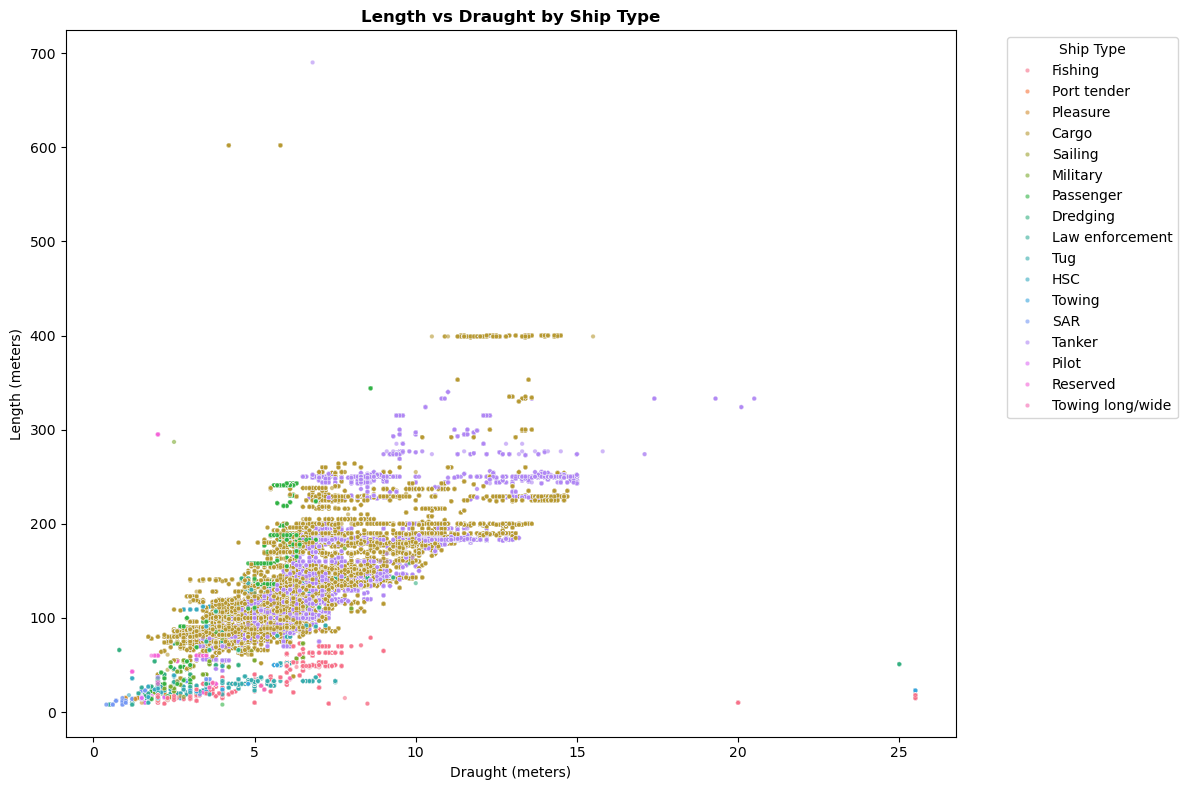

In [33]:
# Length vs Draught (colored by Ship Type)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="draught",
    y="length",
    data=ais_data,
    hue="shiptype",
    alpha=0.6,
    s=10
)
plt.title("Length vs Draught by Ship Type", fontsize=12, fontweight="bold")
plt.xlabel("Draught (meters)")
plt.ylabel("Length (meters)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Ship Type')
plt.tight_layout()
plt.show()

This scatter plot shows how ship length and draught relate for different vessel types. 

Most ships fit an upward trend - bigger ships usually have deeper draughts. 

Groups of points stand out for main types like cargo, tanker, and passenger ships. 

There are also some outliers, such as ships with very small draughts but long lengths, or very large draughts for short ships - these are probably AIS reporting errors. 

This plot shows a strong positive relationship between ship size and draught, and the outliers mean we should do some targeted cleaning before modeling.

## Data Preprocessing 

**Drop**:
- `mmsi`: Heatmap shows MMSI correlates ~0.47 with width, length, and draught—suggesting it encodes vessel class or registration, which could leak vessel type/class information into models.
- `Unamed: 0`: Index column. 

**Use with precision**:
- `heading` and `cog`: These are highly correlated (0.96), which is expected. Keep both, but clip values to [0, 360], and remove outliers above 360° (as seen in the data).
- `sog`: Has good predictive power. Remove extreme outliers above 60 knots and be aware that some values are unusual (as seen in scatterplots).

**Keepers**:
- `shiptype`
- `width`
- `length`
- `draught`


#### In summary:

**Dynamic movement features**:
- `cog`
- `sog`
- `heading`

**Static movement features**:
- `shiptype`
- `width`
- `length`
- `draught`

**Target**:
- `navigationalstatus`

### Functions in src/preprocessing.py:

- `load_raw_ais(path: str)`
    This function reads the raw AIS CSV into a DataFrame and drops ID-like columns such as `mmsi` and `Unnamed: 0`. That prevents the model from memorizing vessel identities or using meaningless index artifacts.


- `filter_physical_outliers(df: pd.DataFrame)`
    This function removes rows with physically impossible or extremely unlikely values for speed, heading, and ship dimensions. It keeps only entries within conservative, domain-informed ranges so the model trains on realistic data.


- `clean_types_and_missing(df: pd.DataFrame)`
    This function standardizes column types (numeric vs. string) and strips whitespace from categorical fields like `shiptype` and `navigationalstatus`. It then drops any rows missing the target or `shiptype`, ensuring every training example is usable.


- `get_features_and_target(df: pd.DataFrame)`
    This function builds the feature matrix `X` from the numeric and categorical predictors and the target vector `y` from `navigationalstatus`. It cleanly separates what the model will use to predict from what it is trying to predict.


- `drop_rare_classes(X: pd.DataFrame, y: pd.Series, min_samples: int = 50)`
    This function removes navigational status classes that have fewer than `min_samples` examples in the dataset. That focuses the model on classes with enough data to learn and avoids issues with stratified splitting on ultra-rare labels.


- `train_val_test_split(X: pd.DataFrame, y: pd.Series, ...)`
    This function splits the data into train, validation, and test sets while trying to preserve the class distribution via stratified sampling. It also guards against cases where stratification is impossible (e.g., classes with too few samples) and falls back gracefully.


- `build_preprocessor() -> ColumnTransformer`
    This function creates a scikit-learn `ColumnTransformer` that scales numeric features and one-hot encodes the `shiptype` categorical feature. It is designed to plug directly into a modeling pipeline before the classifier.


- `prepare_ais_data(path: str)`
This function runs the entire preprocessing pipeline end-to-end: loading, cleaning, filtering outliers, dropping rare classes, splitting, and building the preprocessor. It returns ready-to-use train/val/test splits plus a preprocessing transformer for model training.

In [34]:
# Import preprocessing pipeline and set data path
# Run end‑to‑end preprocessing pipeline
data_path = "../data/ais_data.csv"
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_ais_data(data_path)

[drop_invalid_classes] Dropped 596 samples with invalid navigational status: ['Unknown value']
[drop_rare_classes] Dropping 1 rare classes with < 50 samples: ['Not under command']


In [35]:
# Inspect resulting split shapes
print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)

Train shape: (227828, 7) Val shape: (32547, 7) Test shape: (65095, 7)


In [36]:
# Check class balance in the training set
print("\nTrain class distribution:")
print(y_train.value_counts(normalize=True))


Train class distribution:
navigationalstatus
Under way using engine                                   0.919461
Constrained by her draught                               0.037686
Engaged in fishing                                        0.01509
Moored                                                   0.010359
Reserved for future amendment [HSC]                      0.005372
Restricted maneuverability                               0.004982
Under way sailing                                         0.00406
At anchor                                                 0.00151
Power-driven vessel towing astern                        0.000755
Power-driven vessel pushing ahead or towing alongside    0.000724
Name: proportion, dtype: Float64


In [37]:
# Check class balance in the validation set
print("\nVal class distribution:")
print(y_val.value_counts(normalize=True))


Val class distribution:
navigationalstatus
Under way using engine                                    0.91947
Constrained by her draught                               0.037669
Engaged in fishing                                       0.015086
Moored                                                   0.010354
Reserved for future amendment [HSC]                      0.005377
Restricted maneuverability                               0.004977
Under way sailing                                        0.004056
At anchor                                                0.001506
Power-driven vessel towing astern                        0.000768
Power-driven vessel pushing ahead or towing alongside    0.000737
Name: proportion, dtype: Float64


In [38]:
# Check class balance in the test set
print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))


Test class distribution:
navigationalstatus
Under way using engine                                   0.919456
Constrained by her draught                               0.037699
Engaged in fishing                                       0.015086
Moored                                                   0.010354
Reserved for future amendment [HSC]                      0.005361
Restricted maneuverability                               0.004993
Under way sailing                                        0.004056
At anchor                                                0.001521
Power-driven vessel towing astern                        0.000753
Power-driven vessel pushing ahead or towing alongside    0.000722
Name: proportion, dtype: Float64


In [39]:
# Recombine splits into a modeling DataFrame
X_all = pd.concat([X_train, X_val, X_test])
y_all = pd.concat([y_train, y_val, y_test])

df_model = X_all.copy()
df_model["navigationalstatus"] = y_all

df_model[["sog", "cog", "heading", "width", "length", "draught"]].describe()

,sog,cog,heading,width,length,draught
count,325470.000000,325470.000000,325470.000000,325470.000000,325470.000000,325470.000000
mean,11.764619,190.688047,190.690644,21.206563,133.950893,6.587359
std,3.984557,107.556556,107.229365,10.311213,66.413112,2.802176
min,0.000000,0.000000,0.000000,2.000000,8.000000,0.400000
25%,9.600000,123.200000,124.000000,13.000000,88.000000,4.700000
50%,11.500000,169.200000,170.000000,18.000000,120.000000,6.200000
75%,13.400000,307.300000,306.000000,28.000000,183.000000,7.900000
max,41.700000,359.900000,359.000000,78.000000,400.000000,25.000000


In [40]:
# Save model-ready data in ../data/ais_data_model_ready.csv
model_ready_path = "../data/ais_data_model_ready.csv"
df_model.to_csv(model_ready_path, index=False)
print(f"Model-ready data saved to {model_ready_path}")

Model-ready data saved to ../data/ais_data_model_ready.csv


In [41]:
# Sanity check differences between raw and model-ready data
raw = pd.read_csv("../data/ais_data.csv")
model = pd.read_csv("../data/ais_data_model_ready.csv")

print("Shape:")
print(f"  Raw: {raw.shape}")
print(f"  Model-ready: {model.shape}")

print("\nColumns:")
print(f"  Raw: {list(raw.columns)}")
print(f"  Model-ready: {list(model.columns)}")

print("\nID columns removed?")
print(f"  mmsi in raw: {'mmsi' in raw.columns}, in model: {'mmsi' in model.columns}")
print(f"  Unnamed: 0 in raw: {'Unnamed: 0' in raw.columns}, in model: {'Unnamed: 0' in model.columns}")

print("\nTarget classes:")
raw_classes = raw["navigationalstatus"].value_counts()
model_classes = model["navigationalstatus"].value_counts()
print(f"  Raw: {len(raw_classes)} classes")
print(f"  Model-ready: {len(model_classes)} classes")
print(f"  Dropped: {set(raw_classes.index) - set(model_classes.index)}")

Shape:
  Raw: (358351, 10)
  Model-ready: (325470, 8)

Columns:
  Raw: ['Unnamed: 0', 'mmsi', 'navigationalstatus', 'sog', 'cog', 'heading', 'shiptype', 'width', 'length', 'draught']
  Model-ready: ['sog', 'cog', 'heading', 'width', 'length', 'draught', 'shiptype', 'navigationalstatus']

ID columns removed?
  mmsi in raw: True, in model: False
  Unnamed: 0 in raw: True, in model: False

Target classes:
  Raw: 13 classes
  Model-ready: 10 classes
  Dropped: {'Unknown value', 'Reserved for future amendment [WIG]', 'Not under command'}


## Post-preprocessing EDA

Now that preprocessing is complete and the splits are created, we briefly re-check the cleaned feature space and label distribution to confirm that the data is ready for modeling.


In [42]:
# Check for remaining missing values in the modeling DataFrame
missing_after_preprocessing = df_model.isna().sum().sort_values(ascending=False)
print(missing_after_preprocessing)

sog                   0
cog                   0
heading               0
width                 0
length                0
draught               0
shiptype              0
navigationalstatus    0
dtype: int64


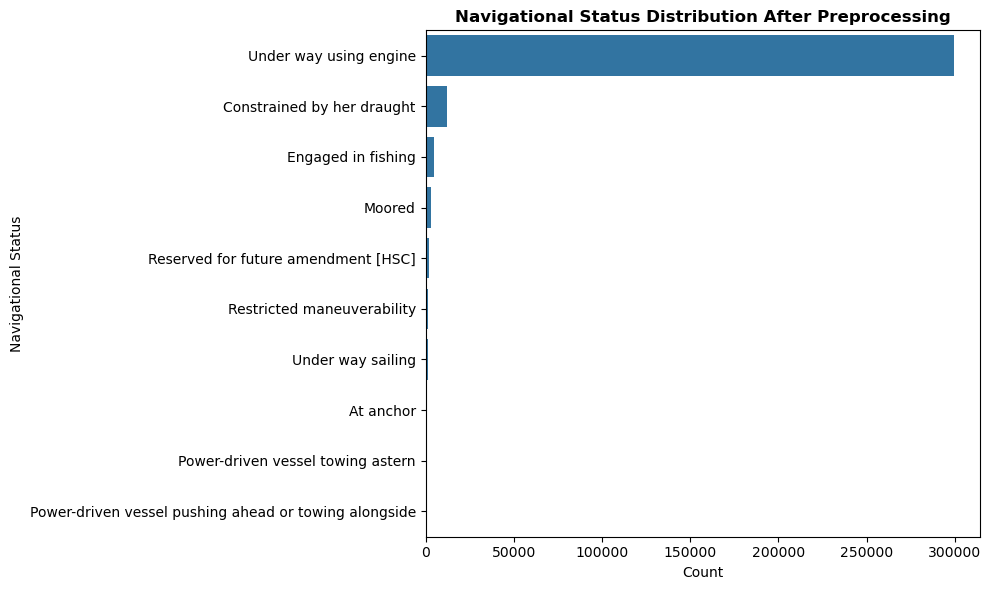

In [43]:
# Navigational status distribution after preprocessing (rare classes dropped)
plt.figure(figsize=(10, 6))
status_counts = df_model["navigationalstatus"].value_counts()
sns.barplot(x=status_counts.values, y=status_counts.index, orient="h")
plt.title("Navigational Status Distribution After Preprocessing", fontsize=12, fontweight="bold")
plt.xlabel("Count")
plt.ylabel("Navigational Status")
plt.tight_layout()
plt.show()

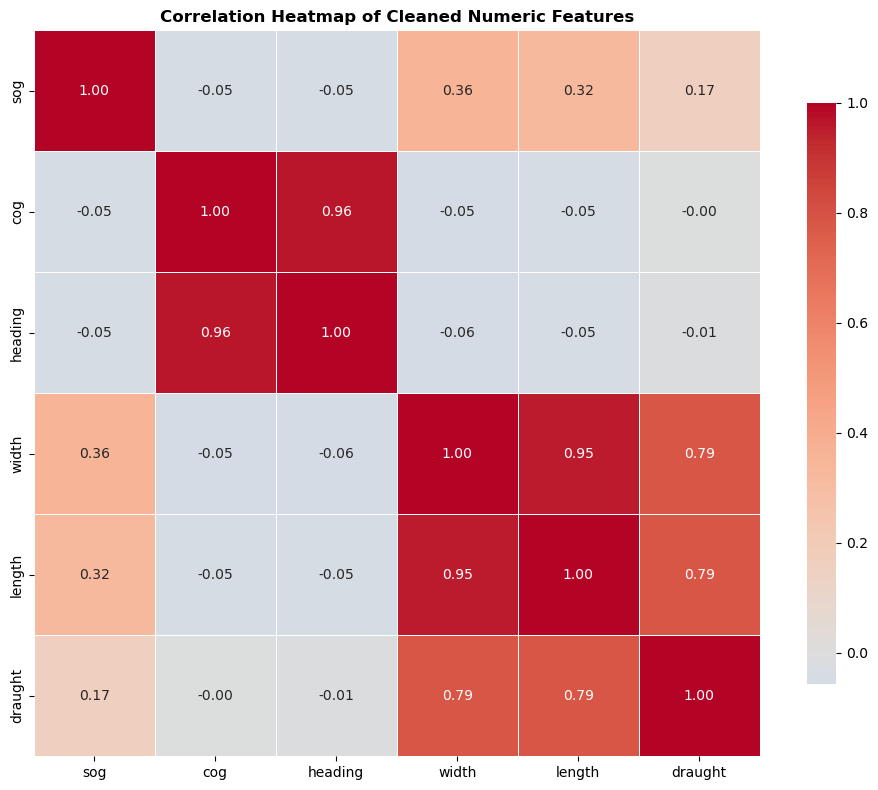

In [44]:
# Correlation heatmap on cleaned numeric features (post-outlier filtering)
clean_corr = df_model[["sog", "cog", "heading", "width", "length", "draught"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    clean_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Cleaned Numeric Features", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()